#### Imports and env creation

In [ ]:
# from __future__ import annotations

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.constants import IDX_TO_OBJECT, OBJECT_TO_IDX
import gymnasium as gym

from minigrid.core.actions import Actions
from dataclasses import dataclass, field 
from typing import Set
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

pygame 2.5.2 (SDL 2.28.2, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [104]:
WORLD_N=8
WORLD_N_SQ = WORLD_N**2

# class SimpleEnv(MiniGridEnv):
#     def __init__(
#         self,
#         size=WORLD_N,
#         agent_start_pos=(1, 1),
#         agent_start_dir=0,
#         max_steps: int | None = None,
#         **kwargs,
#     ):
#         self.agent_start_pos = agent_start_pos
#         self.agent_start_dir = agent_start_dir

#         mission_space = MissionSpace(mission_func=self._gen_mission)

#         super().__init__(
#             mission_space=mission_space,
#             grid_size=size,
#             max_steps=256,
#             **kwargs,
#         )

#     @staticmethod
#     def _gen_mission():
#         return "grand mission"
    
    
#     def _gen_grid(self, width, height):
#       self.grid = Grid(width, height)
#       self.grid.wall_rect(0, 0, width, height)

#       if self.agent_start_pos is not None:
#           self.agent_pos = self.agent_start_pos
#           self.agent_dir = self.agent_start_dir
#       else:
#           self.place_agent()
#       self.valid_actions = {Actions.left, Actions.right, Actions.forward}
    
      
#       self.put_obj(Goal(), width - 2, height - 2)
      
#       self.grid.set(3, 1, Wall())
#       self.grid.set(3, 2, Wall())
#       self.grid.set(3, 4, Wall())
#       self.grid.set(3, 5, Wall())
    
#     def get_array_repr(self, with_agent=True):
#         grid_array = self.unwrapped.grid.encode()[:,:,0]
    
#         grid_array[self.agent_pos[0],self.agent_pos[1]]=OBJECT_TO_IDX['agent']
#         return grid_array.T
    
env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0", render_mode="rgb_array")
env.valid_actions = {Actions.left, Actions.right, Actions.forward}

# env = SimpleEnv(render_mode="human")
# manual_control = ManualControl(env, seed=42)

def get_array_repr(env):
    grid_array = env.unwrapped.grid.encode()[:,:,0]
    # print(grid_array)
    # print(self.agent_pos)
    grid_array[env.agent_pos[0],env.agent_pos[1]]=OBJECT_TO_IDX['agent']
    return grid_array.T

# env = SimpleEnv()
env.reset()
print(get_array_repr(env))

# enable manual control for testing
# manual_control.start()

map_numbers = [1,2,3,4,5,6,7,8,9,10]


[[ 2  2  2  2  2  2  2  2]
 [ 2 10  1  1  1  1  1  2]
 [ 2  1  1  1  6  1  1  2]
 [ 2  1  1  1  1  1  1  2]
 [ 2  1  1  6  1  1  1  2]
 [ 2  1  1  1  1  1  1  2]
 [ 2  1  1  6  1  6  8  2]
 [ 2  2  2  2  2  2  2  2]]


/mnt/c/Users/tiago/Desktop/Code/SURFiN/mg10/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(


<class 'gymnasium.wrappers.order_enforcing.OrderEnforcing'>


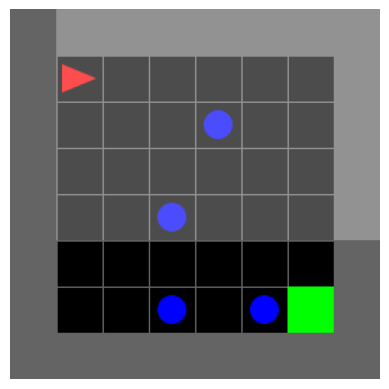

In [ ]:
# print(type(env))
# env_core = env.unwrapped
# plt.axis('off')
# plt.imshow(env_core.render())

#### Agent motion

In [11]:
from agents.random import RandomAgent
n_steps_train = 8000
n_steps_test = 2000

random_action_agent = RandomAgent(valid_actions=env.valid_actions)

dirarr = ['Right', 'Down', 'Left','Up']
actions_to_idx = {Actions.left:0, Actions.right:1, Actions.forward:2}

image_list_train = []

for i in range(n_steps_train):
    action = random_action_agent.act()
    arr = get_array_repr(env).flatten()
    arr = np.append(arr, [actions_to_idx[action], env.agent_dir])
    image_list_train.append(arr)
    # print(dirarr[env.agent_dir])
    # print(action)
    env.step(action)
    # print(env.get_array_repr())

env.reset()
image_list_test = []

for i in range(n_steps_test):
    action = random_action_agent.act()
    arr = get_array_repr(env).flatten()
    arr = np.append(arr, [actions_to_idx[action], env.agent_dir])
    image_list_test.append(arr)
    # print(dirarr[env.agent_dir])
    # print(action)
    env.step(action)

print(image_list_train[:3])

/mnt/c/Users/tiago/Desktop/Code/SURFiN/mg10/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_dir to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_dir` for environment variables or `env.get_wrapper_attr('agent_dir')` that will search the reminding wrappers.
  logger.warn(


[array([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  6,  1,  1,  1,  2,  2,
        6,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        1,  6,  1,  1,  1,  2,  2,  1,  1,  1,  6,  1,  1,  2,  2,  1,  1,
        1,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0]), array([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  6,  1,  6,  1,  1,  2,  2,
        1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        1,  1,  1,  1,  1,  2,  2,  1,  1,  6,  1,  1,  1,  2,  2,  1,  1,
        6,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0]), array([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  6,  1,  1,  1,  2,  2,
        1,  1,  6,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        6,  1,  1,  1,  1,  2,  2,  1,  1,  1,  6,  1,  1,  2,  2,  1,  1,
        1,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  3])]


In [111]:
print(image_list_train[:3])
print(image_list_test[:3])

[array([ 2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  2,  1,  1,  2,  2,  1,  1,
        2,  1,  1,  2,  2,  1,  1,  1,  1,  1,  2,  2,  1,  1,  2,  1,  1,
        2,  2,  1,  1,  2,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  1,  0]), array([ 2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  2,  1,  1,  2,  2,  1,  1,
        2,  1,  1,  2,  2,  1,  1,  1,  1,  1,  2,  2,  1,  1,  2,  1,  1,
        2,  2,  1,  1,  2,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1]), array([ 2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  1,  1,  2,  2, 10,  1,
        2,  1,  1,  2,  2,  1,  1,  1,  1,  1,  2,  2,  1,  1,  2,  1,  1,
        2,  2,  1,  1,  2,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1])]
[array([ 2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  2,  1,  1,  2,  2,  1,  1,
        2,  1,  1,  2,  2,  1,  1,  1,  1,  1,  2,  2,  1,  1,  2,  1,  1,
        2,  2,  1,  1,  2,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0]), array([ 2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  2,  1,  1,  2,  2,  1,  1,
        2,  1, 

#### Helper functions

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())  # This should return True if CUDA is available
print(torch.cuda.current_device())  # Shows the current GPU device id (e.g., 0)
print(torch.cuda.get_device_name(0))  # Displays the GPU name
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f"Using device: {device}")

2.1.1+cu121
True
0
NVIDIA GeForce MX330
Using device: cuda


In [79]:
#(Modified) Neuromatch helper funcitons
def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)
    

def runSGD(net, input_train, target_train, input_test, target_test, criterion='mse',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        print final loss

  Returns:
    Nothing.
  """

  # 1. Define the device
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device = torch.device('cuda')
  print(f"Using device: {device}")

  # 2. Move the network to the device
  net.to(device)

  # 3. Move the main tensors to the device (crucial for initial setup)
  input_train = input_train.to(device)
  target_train = target_train.to(device)
  input_test = input_test.to(device)
  target_test = target_test.to(device)

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  elif criterion == 'cel':
    loss_fn = nn.CrossEntropyLoss() 
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Move the loss function to the device if it has parameters (CrossEntropyLoss does not, 
  # but it's good practice for others like L1Loss which might have reduction='none')
  loss_fn.to(device)

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    
    shuffle_idx = np.random.permutation(len(input_train))

    batches_input = torch.split(input_train[shuffle_idx], batch_size)
    batches_target = torch.split(target_train[shuffle_idx], batch_size)

    batches = zip(batches_input, batches_target)


    shuffle_idx = np.random.permutation(len(input_train))
    # batches = torch.split(input_train[shuffle_idx], batch_size)
    # for batch in batches:
    #   output_train = net(batch)
    #   loss = loss_fn(output_train, batch)
    for batch_input, batch_target in batches:
      batch_input = batch_input.float()
      batch_target = batch_target.float()
      output_train = net(batch_input)  # Forward pass on the input batch
      loss = loss_fn(output_train, batch_target)  # Compare output with the target
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, target_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, target_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, target_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, target_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, target_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, target_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()
  print(device)


#### Input preparation

In [36]:
# test_size=0.2
# cutoff = int((1-test_size)*len(image_list))
X_train, X_test = image_list_train, image_list_test 

target_train = X_train[1:]
input_train = X_train[:-1]
target_test = X_test[1:]
input_test = X_test[:-1]

target_train = torch.tensor(target_train, dtype=torch.int64)
input_train = torch.tensor(input_train, dtype=torch.int64)
target_test = torch.tensor(target_test, dtype=torch.int64)
input_test = torch.tensor(input_test, dtype=torch.int64)


def one_hot_encode_set(values, classes):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    one_hot = torch.zeros(len(classes))
    one_hot[classdict[values.item()]] = 1
    return one_hot

def continuous_class(values, classes, direct):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    val = classdict[values.item()]
    if (values.item()==10):
        val+=direct
    return torch.tensor([val])


# Define a function for one-hot encoding
def one_hot_encode(values, num_classes):
    one_hot = torch.zeros(num_classes)
    one_hot[values] = 1
    return one_hot

# Function to process the entire array (each input array of shape [length])
def process_input(input_array, mode):
    if mode == 'in':
    
        # first_part = torch.cat([one_hot_encode(input_array[i], 11) for i in range(25)])
        # first_part = torch.cat([one_hot_encode_set(input_array[i], map_numbers) for i in range(25)])
        first_part = torch.cat([continuous_class(input_array[i], map_numbers, input_array[1+WORLD_N_SQ]) for i in range(WORLD_N_SQ)])

        # 26th position: one-hot encoded into 3 classes
        second_part = one_hot_encode(input_array[WORLD_N_SQ], 3)
        
        # Last position: one-hot encoded into 4 classes
        # third_part = one_hot_encode(input_array[26], 4)

        # print(torch.cat([first_part, second_part, third_part], dim=0))
        # Concatenate all parts to form the final one-hot encoded array
        return torch.cat([first_part, second_part], dim=0)
    elif mode == 'out':
        return torch.cat([continuous_class(input_array[i], map_numbers, input_array[1+WORLD_N_SQ]) for i in range(WORLD_N_SQ)])


# Apply to the whole dataset
input_orientation_train = [x[1+WORLD_N_SQ] for x in input_train]
input_orientation_test = [x[1+WORLD_N_SQ] for x in input_test]
target_orientation_train = [x[1+WORLD_N_SQ] for x in target_train]
target_orientation_test = [x[1+WORLD_N_SQ] for x in target_test]

# Apply to the whole dataset
input_train_processed = torch.stack([process_input(x, 'in') for x in input_train])
input_test_processed = torch.stack([process_input(x, 'in') for x in input_test])
target_train_processed = torch.stack([process_input(x, 'out') for x in target_train])
target_test_processed = torch.stack([process_input(x, 'out') for x in target_test])


print(target_train)
print(input_train)


tensor([[2, 2, 2,  ..., 2, 0, 0],
        [2, 2, 2,  ..., 2, 0, 3],
        [2, 2, 2,  ..., 2, 0, 2],
        ...,
        [2, 2, 2,  ..., 2, 0, 2],
        [2, 2, 2,  ..., 2, 1, 1],
        [2, 2, 2,  ..., 2, 1, 2]])
tensor([[2, 2, 2,  ..., 2, 2, 0],
        [2, 2, 2,  ..., 2, 0, 0],
        [2, 2, 2,  ..., 2, 0, 3],
        ...,
        [2, 2, 2,  ..., 2, 0, 3],
        [2, 2, 2,  ..., 2, 0, 2],
        [2, 2, 2,  ..., 2, 1, 1]])


#### Autoencoder definition

In [75]:
# RNN Module

class RNNOutOnly(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.rnn = nn.RNN(*args, **kwargs)
    def forward(self, x):
        out, _ = self.rnn(x)
        return out

In [90]:
encoding_size=50
hidden_fac=15
input_size=input_train_processed.size(1)
output_size = target_train_processed.size(1)
model = nn.Sequential(
    nn.Linear(input_size, int(input_size * hidden_fac)),
    nn.ReLU(),
    nn.Linear(int(input_size * hidden_fac), encoding_size),
    nn.ReLU(),
    RNNOutOnly(encoding_size, encoding_size,nonlinearity='relu'),
    nn.Linear(encoding_size, int(output_size * hidden_fac)),
    nn.ReLU(),
    nn.Linear(int(output_size *hidden_fac), output_size),
    )

# model[:-2].apply(init_weights_kaiming_normal)

n_e = 4
n_l = 1
encoder = model[:n_e]
latent = model[n_e:n_e+n_l]
decoder = model[n_e+n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Latent \n\n {latent}\n')
print(f'Decoder \n\n {decoder}')

Encoder 

 Sequential(
  (0): Linear(in_features=67, out_features=1005, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1005, out_features=50, bias=True)
  (3): ReLU()
)

Latent 

 Sequential(
  (4): RNNOutOnly(
    (rnn): RNN(50, 50)
  )
)

Decoder 

 Sequential(
  (5): Linear(in_features=50, out_features=960, bias=True)
  (6): ReLU()
  (7): Linear(in_features=960, out_features=64, bias=True)
)


In [ ]:
# rnn = nn.RNN(input_size=10, hidden_size=20)  # 10 → 20 features

# x = torch.randn(5, 3, 10)  # (seq_len=5, batch=3, input_size=10)
# output, hidden = rnn(x)

# print(output.shape)  
# print(hidden.shape)  

torch.Size([5, 3, 20])
torch.Size([1, 3, 20])


#### Autoencoder training

Using device: cuda
Epoch 	 Loss train 	 Loss test
1/30	 2.8113		 2.8458
2/30	 2.5844		 2.6569
3/30	 2.3964		 2.4988
4/30	 2.3024		 2.4189
5/30	 2.2119		 2.3316
6/30	 2.1408		 2.2712
7/30	 2.1016		 2.2402
8/30	 2.0445		 2.1883
9/30	 2.0153		 2.1641
10/30	 1.9702		 2.1315
11/30	 1.9356		 2.1073
12/30	 1.8916		 2.0670
13/30	 1.8591		 2.0469
14/30	 1.8255		 2.0223
15/30	 1.7978		 2.0030
16/30	 1.7793		 1.9841
17/30	 1.7343		 1.9572
18/30	 1.7172		 1.9620
19/30	 1.6915		 1.9423
20/30	 1.6695		 1.9330
21/30	 1.6389		 1.9169
22/30	 1.6270		 1.9072
23/30	 1.6115		 1.9098
24/30	 1.5854		 1.8942
25/30	 1.5757		 1.9006
26/30	 1.5818		 1.9078
27/30	 1.5436		 1.8922
28/30	 1.5215		 1.8794
29/30	 1.5051		 1.8724
30/30	 1.4888		 1.8781


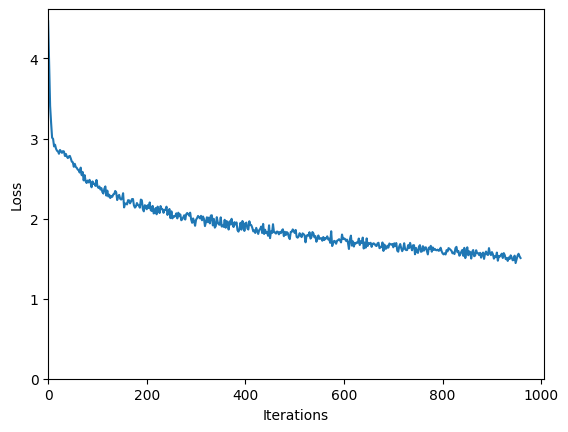

cuda


In [91]:
n_epochs = 30
batch_size = 256

runSGD(model, input_train_processed, target_train_processed, input_test_processed, target_test_processed, n_epochs=n_epochs, batch_size=batch_size)

In [ ]:
input_test_processed = input_test_processed.to(device)
output = model(input_test_processed)  # Model output (logits or probabilities)
# torch.set_printoptions(profile="full")
# print(output)
output = output.cpu() 
# Initialize a list to hold the decoded outputs for each observation
decoded_outputs = []

incorrect_agent_num=0
incorrect_agent_location=0
incorrect_orientation=0
incorrect_cell=0
not_perfect=0

for i in range(output.size(0)):  # Loop over each sample in the batch
    # Extract the blocks of the output
    fist_NSQ = output[i]
    # second_block = output[i, input_train_processed.size(1)-7:input_train_processed.size(1)-4]    # Next block of size 3
    # third_block = output[i, input_train_processed.size(1)-7:]             # Last block of size 4

    # Decode each block by taking the argmax (index of max value)
    decoded_fist_NSQ = torch.round(fist_NSQ).long()  # 25 values, each between 0-10
    # decoded_second = torch.argmax(second_block)       # Single value between 0-2
    # decoded_third = torch.argmax(third_block)         # Single value between 0-3
    
    map_array = map_numbers+[11,12,13]
    in_map_array = torch.isin(decoded_fist_NSQ, torch.tensor(range(len(map_array))))
    # Convert values not in map_array to len(map_array)
    adjusted_values = torch.where(in_map_array, decoded_fist_NSQ, torch.tensor(len(map_array)))
    mapping = torch.tensor(map_array+[-1])
    decoded_fist_NSQ = mapping[adjusted_values]

    num_agents = 0
    maybe_perfect=1

    for j, val in enumerate(decoded_fist_NSQ):
        if val >= 10 and num_agents == 0:
            decoded_second = val -10
            if (target_test[i, j] != 10):
                incorrect_agent_location=1
                maybe_perfect=0
        if val>= 10:
            num_agents +=1
        if (target_test[i, j] != val and (val < 10 or target_test[i, j] < 10)):
            # print("cell", i)
            maybe_perfect=0
            incorrect_cell +=1
    
    decoded_fist_NSQ[decoded_fist_NSQ > 10] = 10

    if num_agents != 1:
        decoded_second = torch.tensor(-1, dtype=torch.long)
        maybe_perfect=0
        incorrect_agent_num +=1
    
    if (decoded_second != target_orientation_test[i]):
        maybe_perfect=0
        incorrect_orientation +=1

    if not maybe_perfect:
        not_perfect +=1

    # Use torch.masked_select to get all matching values
    matches = torch.masked_select(decoded_fist_NSQ, decoded_fist_NSQ >= 10)

    # Ensure it's a 1D tensor for concatenation
    decoded_second = decoded_second.unsqueeze(0)

    # Combine the decoded values into a single list for this observation
    decoded_sample = torch.cat([decoded_fist_NSQ, decoded_second])
    
    # Append the decoded sample to the final list
    decoded_outputs.append(decoded_sample)

acc_cell = 1.0-(incorrect_cell/(WORLD_N_SQ*output.size(0)))
acc_orientation = 1.0-(incorrect_orientation/output.size(0))
acc_agentloc = 1.0-(incorrect_agent_location/output.size(0))
acc_agentnum = 1.0-(incorrect_agent_num/output.size(0))
acc_perfect = 1.0-(not_perfect/output.size(0))

# Convert to tensor if needed
decoded_outputs = torch.stack(decoded_outputs)
print(decoded_outputs)

print ("Cell accuracy:", acc_cell)
print ("Agent orientation accuracy:", acc_orientation)
print ("Number of agents accuracy:", acc_agentnum)
print ("Agent location accuracy:", acc_agentloc)
print ("Perfectness:", acc_perfect)

tensor([[ 2,  2,  2,  ...,  2,  2, -1],
        [ 2,  2,  2,  ...,  2,  2, -1],
        [ 2,  2,  2,  ...,  2,  2,  0],
        ...,
        [ 2,  2,  2,  ...,  2,  2, -1],
        [ 2,  2,  2,  ...,  2,  2, -1],
        [ 2,  2,  2,  ...,  2,  2, -1]])
Cell accuracy: 0.6818018384192096
Agent orientation accuracy: 0.11305652826413204
Number of agents accuracy: 0.423711855927964
Agent location accuracy: 0.9894947473736868
Perfectness: 0.0


In [63]:
interval_min=1300
interval_size=30
for i in range(interval_min,interval_min+min(interval_size,decoded_outputs.size(0))):
    # Print the input, decoded grid, and target test grid side by side
    print(f"Sample {i + 1}:")
    
    # Input grid (first 25 values reshaped into 5x5)
    print("Input Grid:")
    print(input_test[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Decoded grid (first 25 values reshaped into 5x5)
    print("Decoded Grid:")
    print(decoded_outputs[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Target test grid (first 25 values reshaped into 5x5)
    print("Target Grid:")
    print(target_test[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Action and Orientation for input, decoded, and target test
    print(f"Input Action: {input_test[i, WORLD_N_SQ].item()}")
    print(f"Decoded Orientation: {decoded_outputs[i, WORLD_N_SQ].item()} | Target Orientation: {target_orientation_test[i].item()} | Input Orientation: {input_orientation_test[i].item()}")
    
    print("=" * 50)  # Separator


Sample 1301:
Input Grid:
tensor([[ 2,  2,  2,  2,  2,  2,  2,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  6,  6,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1, 10,  1,  2],
        [ 2,  1,  1,  1,  6,  1,  1,  2],
        [ 2,  6,  1,  1,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2,  2,  2,  2]], dtype=torch.int32)
Decoded Grid:
tensor([[ 2,  2,  2,  2,  2,  2,  2,  2],
        [ 2,  1,  2,  2,  1,  1,  1,  2],
        [ 2,  1,  3,  1,  1,  1,  2,  2],
        [ 2,  2,  2,  3,  2,  1,  1,  2],
        [ 2,  1, -1,  1,  1, 10,  2,  2],
        [ 2,  3,  3,  2,  1,  2,  1,  2],
        [ 2,  1,  2,  1,  1,  1,  7,  2],
        [ 2,  2,  2,  2,  2,  2,  2,  2]], dtype=torch.int32)
Target Grid:
tensor([[ 2,  2,  2,  2,  2,  2,  2,  2],
        [ 2,  1,  6,  6,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1, 10,  1,  2],
        [ 2,  1,  6,  1,  